In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler 
import category_encoders as one_hot
import joblib
from sklearn.linear_model import LogisticRegression



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Import Dataset

In [2]:
#train file
titanic_df = pd.read_csv('../input/titanic/train.csv')
titanic_df_copy = titanic_df.copy()

#test file (for submission)
titanic_test = pd.read_csv('../input/titanic/test.csv')
titanic_test_copy = titanic_test.copy()

#sample submission
titanic_submission_file = pd.read_csv('../input/titanic/gender_submission.csv')

## Data Notes

**Survival**
- 0 = No, 1 = Yes

**Pclass (Ticket class)**
- 1=1st, 2=2nd, 3=3rd

**Sex**
- male, female

**Age** 
- Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**Sibsp** 
- number of sibling/spouses aboard the Titanic
- sibling = brother, sister, stepbrother, stepsister
- spouse = husband, wife (mistresses and fiancés were ignored)

**Parch** 
- number of parents/children aboard the Titanic
- parent = mother, father
- child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

**Ticket**
- ticket number

**Fare** 
- passenger fare

**Cabin** 
- cabin number

**Embarked** 
- port of Embarkation 
- C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
#sample data
titanic_df_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**From the sample data, new things that can be found in the dataset:**

*Name column*
- has the format of 'last name, title first name'

*Ticket column*
- some ticket has the some kind of identity for example 'A/5, PC' and some just a full number


In [4]:
titanic_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**From this information,**

- it is known that the dataset consist a total 891 passengers each with 10 features information

- some features has missing value

1. Age = 891 - 714 = 177
2. Cabin = 891 - 204 = 687
3. Embarked = 891 - 889 = 2

- Since cabin has a very high missing value, therefore cabin will be removed for this notebook

In [5]:
titanic_df_copy.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**From this information,**

- The data are not normalized since all of the columns has different range with each other
- Looks like there are outliers exist in some of the features such as 'Age', 'Fare' and 'SibSp' (for future analysis)

# EDA

In [6]:
#before we go to eda, we try to fix the Name column and Ticket column so that it can be fit into the eda

## Name Column

In [7]:
# Name column
# the idea to handle this column is by classified them by title such as Mr, Miss, Mrs, Ms, No Title,....

#but first, need to identify the set of title exist in the dataset,
#since it is known that the format of the name is 'last name, title first name' -> can be handled by splitting the name by ' ' and get the second part
#it may not be true for all the name, however it is the approach that will be use for this notebook


#save the list of title into the title box and print the unique 
title_box = []
titanic_df_copy['Name'].apply(lambda x: title_box.append(x.split(" ")[1]))
title = set(title_box)
print(title)


{'Gordon,', 'Carlo,', 'Velde,', 'Mr.', 'Melkebeke,', 'Capt.', 'Shawah,', 'Steen,', 'Major.', 'Master.', 'Col.', 'Mrs.', 'Mulder,', 'Billiard,', 'der', 'Walle,', 'Rev.', 'the', 'Mme.', 'Cruyssen,', 'Don.', 'y', 'Dr.', 'Pelsmaeker,', 'Impe,', 'Messemaeker,', 'Planke,', 'Mlle.', 'Jonkheer.', 'Miss.', 'Ms.'}


**From the title box, the title that will be used from the dataset are:**

*Rev, Master, Mlle, Jonkheerm, Mme, Major, Capt, Mr, Mrs, Col, Don, Miss, Ms*

In [8]:
def checker_title(name):
    
    if 'Rev' in name:
        return 'Rev'
    elif 'Master' in name:
        return 'Master'
    elif 'Mlle' in name:
        return 'Mlle'
    elif 'Jonkheer'in name:
        return 'Jonkheer'
    elif 'Mme' in name:
        return 'Mme'
    elif 'Major' in name:
        return 'Major'
    elif 'Capt' in name:
        return 'Capt'
    elif 'Mr' in name:
        return 'Mr'
    elif 'Mrs' in name:
        return 'Mrs'
    elif 'Col' in name:
        return 'Col'
    elif 'Don' in name:
        return 'Don'
    elif 'Miss' in name:
        return 'Miss'
    elif 'Ms' in name:
        return 'Ms'
    else:
        return 'No Title'
    
titanic_df_copy['Name'] = titanic_df_copy['Name'].apply(lambda x: checker_title(x))

titanic_df_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mr,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mr,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


## Ticket Column

In [9]:
#Ticket Column
#this column is quite tricky since there is no standalone pattern here
#therefore ticket column will be remove since it is just a number similar with PassengerId even ticket has duplicate in the information

## Start Analysis

In [10]:
#group the data according to their nature type for future analysis (ignore Ticket, and Name first)
qualitative_feature =['Survived','Pclass','Sex','Embarked','Name']
quantitative_feature = ['Age', 'SibSp', 'Parch','Cabin']

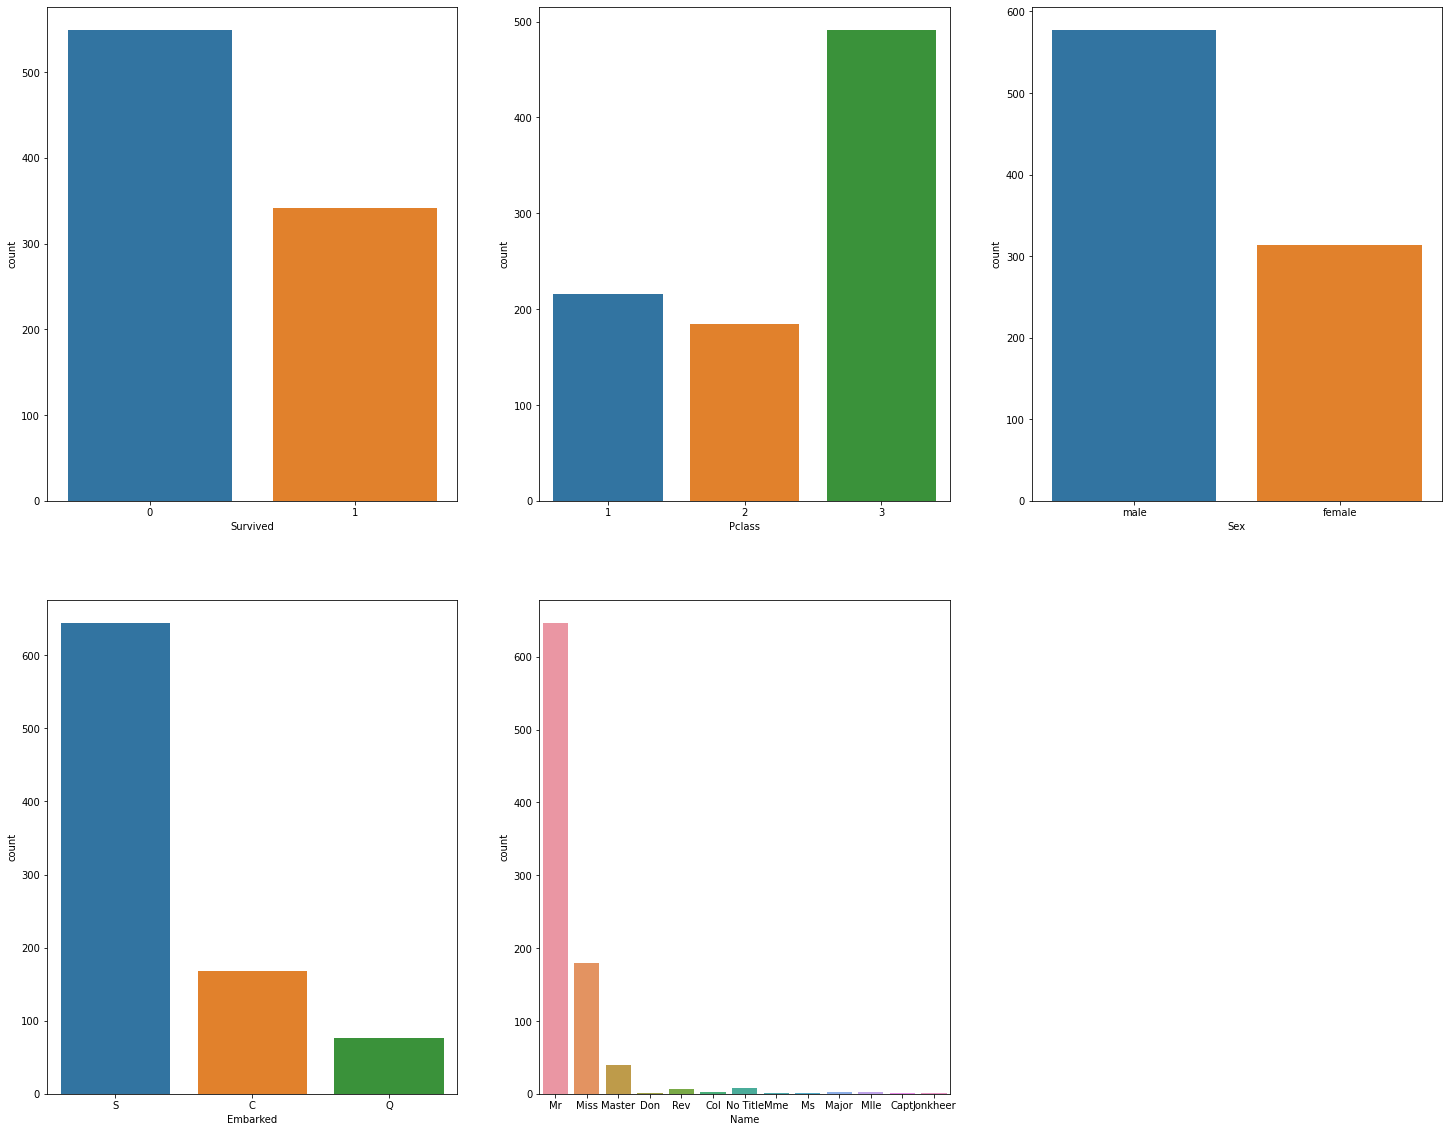

In [11]:
plt.figure(figsize = (25,20))
for i in enumerate(qualitative_feature):
    plt.subplot(2,3, i[0] + 1)
    sns.countplot(x= i[1], data  = titanic_df_copy)

**From the graph:**

1. There are more people who are not survived
2. There are more people who are getting the 3rd class, followed by 1st class and 2nd class
3. There are more male on the ship compare to woman
4. There are more people who embarked from S (Southampton)

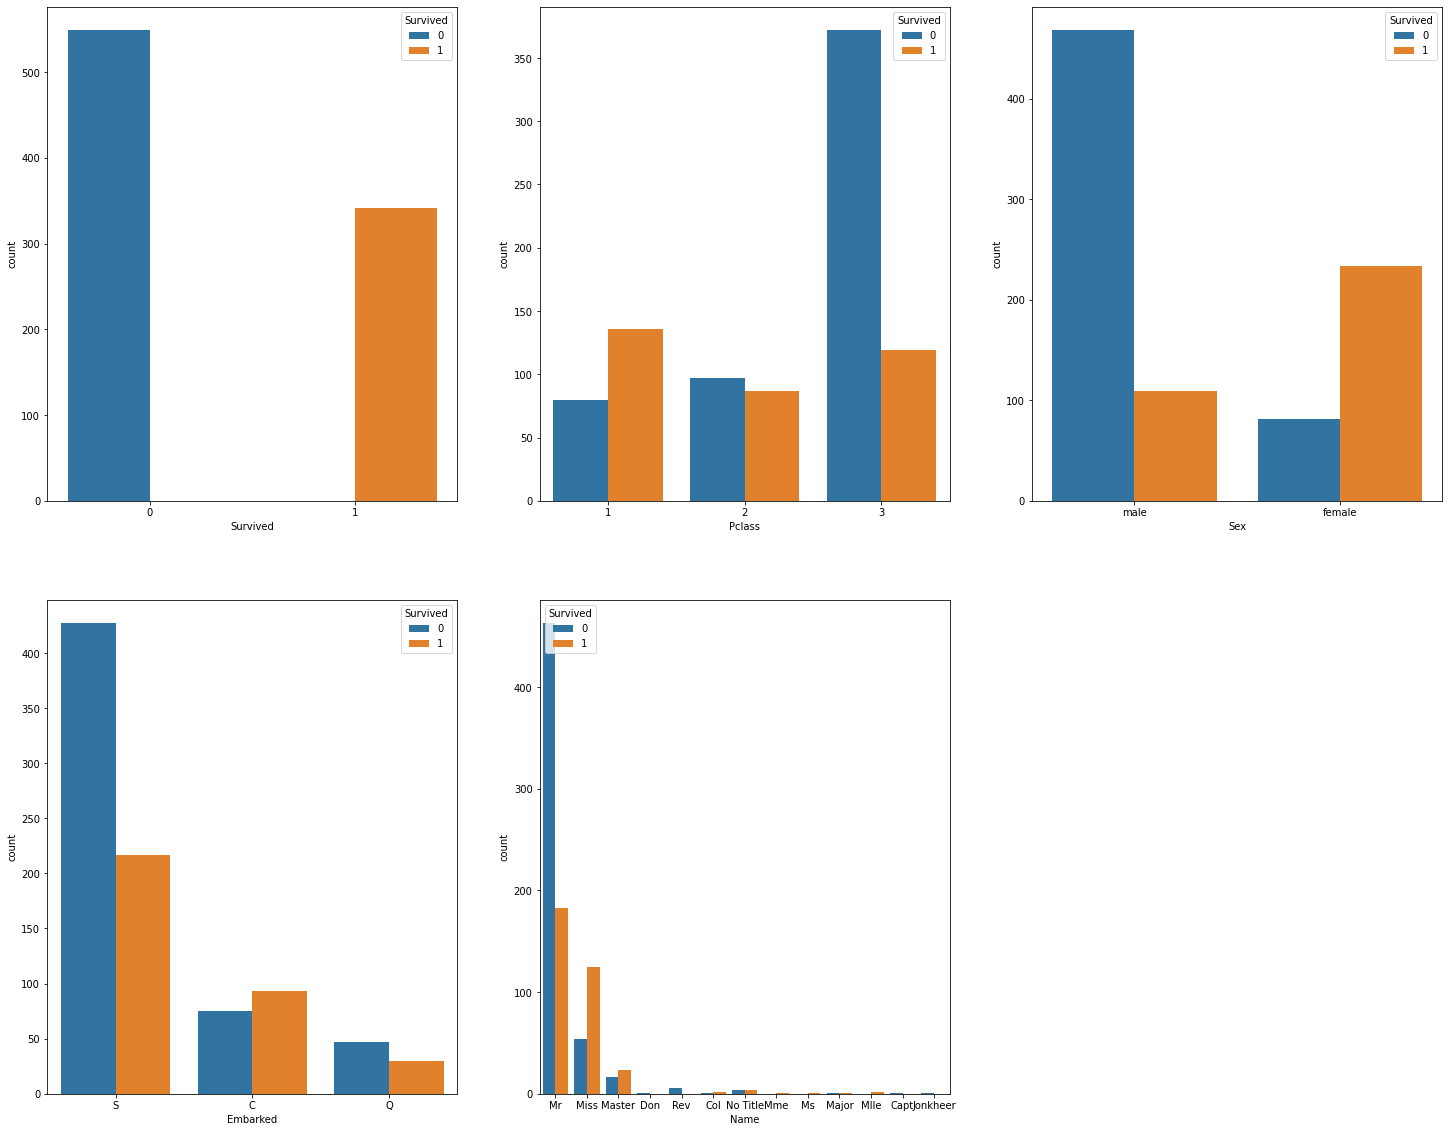

In [12]:
#qualitative_feature.remove('Survived')
plt.figure(figsize = (25,20))
for i in enumerate(qualitative_feature):
    plt.subplot(2,3, i[0] + 1)
    #sns.color_palette("hls", 8)
    sns.countplot(x= i[1], data  = titanic_df_copy, hue = 'Survived')

From the graph:

1. Passenger who got onto the ship using 1st ticket class has a slightly higher chance to survive compare to 2nd and 3rd class. The not survived trend increases for the lower ticket class. Even it is increases, for the 3rd class ticket there are a very huge margin different between passenger who are not survived and survived.

2. Male passenger are more likely to not survived compare to female passenger

3. Passenger who embarked from Southampton also are more likely not to survived by a huge margin different followed by Queenstown with a small margin meanwhile passenger who embarked from Cherbourg has a slight chance to survive 

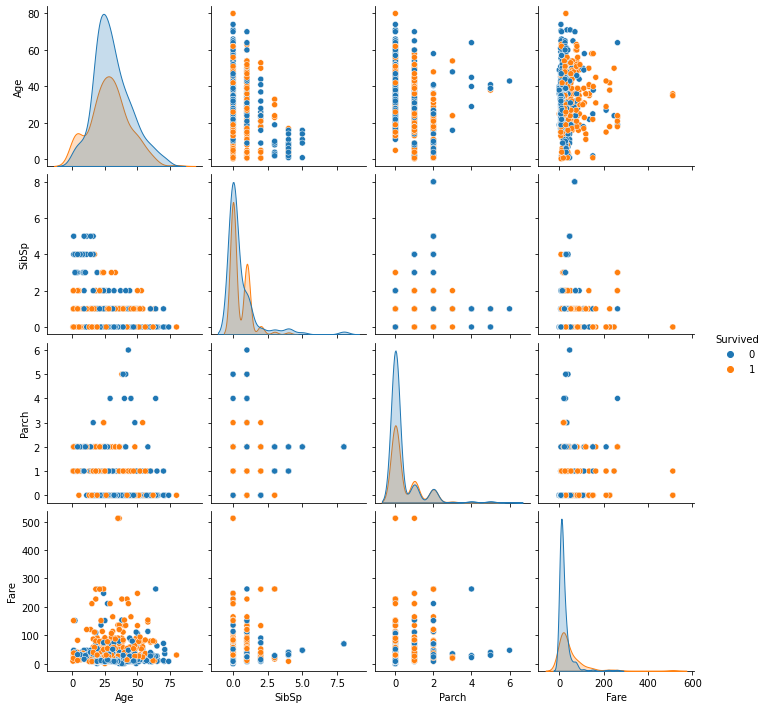

In [13]:
sns.pairplot(data = titanic_df_copy.drop(columns = ['PassengerId','Pclass']), hue = 'Survived')

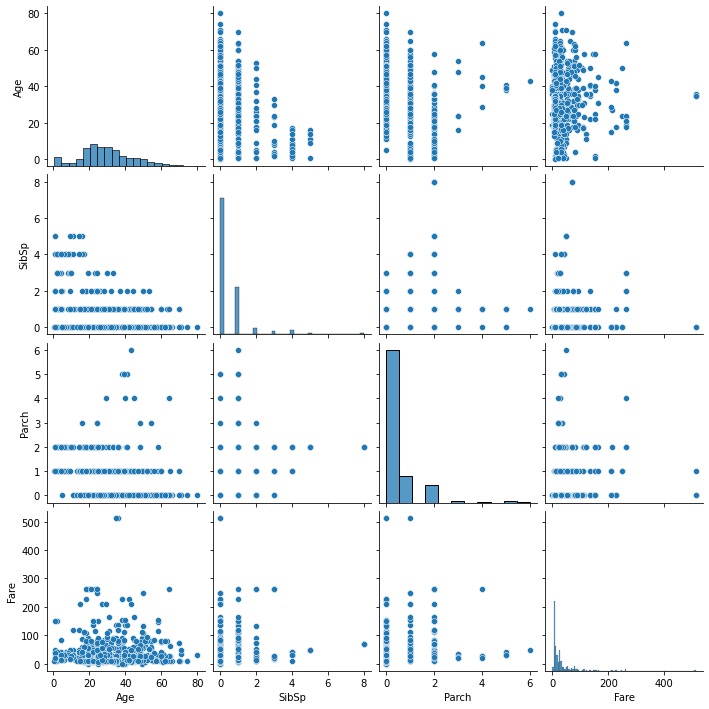

In [14]:
sns.pairplot(data = titanic_df_copy.drop(columns = ['PassengerId','Pclass', 'Survived']))

From the scatter plot:

1. It is most likely for all the passengers not survived the disaster since not survived dominates in every area and there are only a few cases that passengers will likely to survive.
2. However, from the fare graph, it can be seen that passenger that pays a lot (~ $300 and above) has a better chances to survive

<AxesSubplot:>

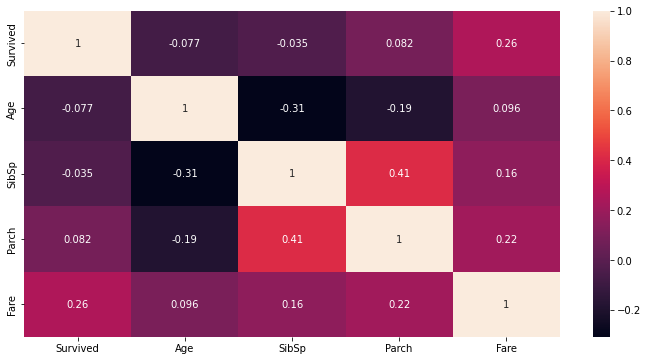

In [15]:
#check the relationship in the heatmap
plt.figure(figsize=(12,6))
sns.heatmap(titanic_df_copy.drop(columns = ['PassengerId','Pclass']).corr(), annot = True)

From the heatmap,

- There is no strong relationship between feature column

# Data Preprocessing

In [16]:
#remove unwanted column -> (PassengerId, Cabin, Ticket)

new_titanic_df = titanic_df_copy.drop(columns = ['PassengerId','Ticket','Cabin'])

In [17]:
#check and remove duplicate rows 
print(f'size dataset before remove duplicate: {new_titanic_df.shape}')
new_titanic_df.drop_duplicates(subset=None, keep='first', inplace=False)
print(f'size dataset after remove duplicate: {new_titanic_df.shape}')

size dataset before remove duplicate: (891, 9)
size dataset after remove duplicate: (891, 9)


It seems like there is no duplicate value exist in the dataset

In [18]:
#fill in missing value
#the column focused are 'Age' and 'Embarked'
#will use mean to fill missing data for 'Age' and mode for 'Embarked'
new_titanic_df['Embarked'] = new_titanic_df['Embarked'].fillna(new_titanic_df['Embarked'].mode()[0])
new_titanic_df['Age'] = new_titanic_df['Age'].fillna(new_titanic_df['Age'].mean())

In [19]:
#check for missing data
print(new_titanic_df.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [20]:
#define the X and y
X = new_titanic_df.drop(columns = 'Survived') 
y = new_titanic_df['Survived']

In [21]:
#Apply one hot encoding to the dataset
#do one-hot-encoding
print(f'before one-hot: {X.shape}')

# Instantiating the Category Encoders OHE object
ohe = one_hot.OneHotEncoder(use_cat_names = True)
ohe.fit(X)
X = ohe.transform(X)


print(f'after one-hot: {X.shape}')

before one-hot: (891, 8)
after one-hot: (891, 23)


In [22]:
#split dataset to train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 0, test_size = 0.2)

In [23]:
#normalize the feature
scale = StandardScaler().fit(X)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)


# Model Training

In [24]:
#for this notebook, model used is Logistic Regression for the baseline model since it is the easiest and fastest model 

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.77      0.77      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



**Based on the results,**

1. It is shown that the baseline model achieved 82% accuracy
2. The model can predict passenger who are not survived better than passenger that have the chances to survive

# Save the baseline model

In [25]:
joblib.dump(ohe, 'ohe.pkl')
joblib.dump(scale, 'scale.pkl')
joblib.dump(model, 'titanic_baseline_model.pkl')

['titanic_baseline_model.pkl']